In [1]:
import os

import pandas as pd
import numpy as np

In [2]:
phish = pd.read_csv('./CSV/simple_phishing.csv')

In [3]:
phish.head()

,SFH,popUpWidnow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result
0,1,-1,1,-1,-1,1,1,1,0,0
1,-1,-1,-1,-1,-1,0,1,1,1,1
2,1,-1,0,0,-1,0,-1,1,0,1
3,1,0,1,-1,-1,0,1,1,0,0
4,-1,-1,1,-1,0,0,-1,1,0,1


In [4]:
print(len(phish))

1353


In [5]:
#Drop all the suspicious label, only wish to keep phishing/legitimate

indexNames = phish[phish['Result'] == 0 ].index
phish.drop(indexNames , inplace=True)

In [6]:
print(len(phish))

1250


In [7]:
phish.rename(columns={"popUpWidnow" : "popUpWindow"})

,SFH,popUpWindow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result
1,-1,-1,-1,-1,-1,0,1,1,1,1
2,1,-1,0,0,-1,0,-1,1,0,1
4,-1,-1,1,-1,0,0,-1,1,0,1
5,-1,-1,1,-1,-1,1,0,-1,0,1
6,1,-1,0,1,-1,0,0,1,0,-1
...,...,...,...,...,...,...,...,...,...,...
1348,-1,-1,-1,-1,-1,-1,0,1,0,1
1349,-1,0,1,0,-1,0,0,1,0,-1
1350,-1,0,-1,-1,-1,0,-1,-1,0,1
1351,0,0,1,0,0,0,-1,1,0,1


In [8]:

##Get the headers name of all columns into a list and remove the Result header as i do not wish to change the results
columns = phish.columns.values.tolist()
columns.remove('Result')



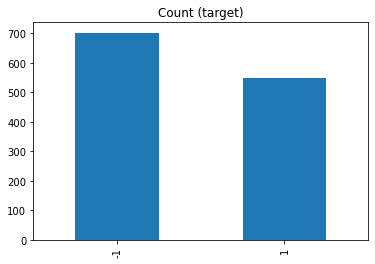

In [18]:
phish['Result'].value_counts().plot(kind='bar', title='Count (target)');

In [10]:
## 1 is phishing, -1 is legitimate
phish['Result'].unique()

##Since all have a IP Address there isnt a need for it
phish = phish.drop(['having_IP_Address'], axis = 1)

In [11]:
from sklearn.model_selection import train_test_split, cross_val_score

y = phish['Result']
X = phish.drop(['Result'], axis = 1)

x_train, x_test, y_train, y_test = train_test_split(X ,y, test_size = 0.30, random_state = 2)

# Gradient Boosting Algorithm

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

lrates = [0.01]
for learning_rate in lrates:
    GBC = GradientBoostingClassifier(learning_rate = learning_rate, n_estimators = 1000, max_depth=8, min_samples_split=2, min_samples_leaf=2, subsample=1, max_features='sqrt', random_state=10)
    GBC.fit(x_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(GBC.score(x_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(GBC.score(x_test, y_test)))

Learning rate:  0.01
Accuracy score (training): 0.973
Accuracy score (validation): 0.923


In [13]:
from sklearn.metrics import roc_auc_score, classification_report
prediction = GBC.predict(x_test)

prediction = prediction.astype(int)
y_test = y_test.astype(int)

print(roc_auc_score(y_test, prediction))
print(classification_report(y_test, prediction))

0.9181328857506657
              precision    recall  f1-score   support

          -1       0.91      0.95      0.93       212
           1       0.94      0.88      0.91       163

    accuracy                           0.92       375
   macro avg       0.92      0.92      0.92       375
weighted avg       0.92      0.92      0.92       375



In [14]:
importances = pd.DataFrame({'Features':x_train.columns,'importance':np.round(GBC.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('Features')
importances.head(10)

,importance
Features,
SFH,0.414
SSLfinal_State,0.176
popUpWidnow,0.155
Request_URL,0.081
URL_of_Anchor,0.062
web_traffic,0.047
URL_Length,0.039
age_of_domain,0.026


In [15]:
import xgboost as xgb

xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(x_train, y_train)

# Predict
preds = xgb_cl.predict(x_test)

xgb_cl.score(x_test, y_test)

[21:51:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\limju\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.92

In [16]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 1000, max_depth=8, min_samples_split=2, min_samples_leaf=2, max_features='sqrt', random_state=10)


rfc.fit(x_train, y_train)
print("Learning rate: ", learning_rate)
print("Accuracy score (training): {0:.3f}".format(rfc.score(x_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(rfc.score(x_test, y_test)))

Learning rate:  0.01
Accuracy score (training): 0.957
Accuracy score (validation): 0.939


In [17]:
importances = pd.DataFrame({'Features':x_train.columns,'importance':np.round(rfc.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('Features')
importances.head(10)

,importance
Features,
SFH,0.408
SSLfinal_State,0.197
popUpWidnow,0.156
Request_URL,0.080
URL_of_Anchor,0.058
web_traffic,0.040
URL_Length,0.033
age_of_domain,0.028
